In [1]:
import pandas
import numpy
from matplotlib import pyplot
from graphviz import Source
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from MAD2 import *

In [2]:
def build_graphs(predictor, params):
    scores = {}
    for param in params:
        scores[param] = []
        for value in params[param]:
            pred = predictor()
            pred.set_params(**{param: value})
            pred.fit(x_train, y_train)
        #print(f"{param} : {value} - {numpy.average(cross_val_score(tree, x_test, y_test))}")
            if isinstance(pred, DecisionTreeClassifier):
                scores[param].append(numpy.average(roc_auc_score(y_test, pred.predict(x_test))))
            else:
                scores[param].append(numpy.average(r2_score(y_test, pred.predict(x_test))))
    for param in params:
        if  isinstance(pred, DecisionTreeClassifier):
            pyplot.title("roc_auc_score to " + param)
        else:
            pyplot.title("R2 to " + param)
        pyplot.plot(params[param], scores[param])
        pyplot.xlabel(param, labelpad=15)
        pyplot.ylabel("score", labelpad=15)
        pyplot.show()
        
def cut_tree(tree):
    if isinstance(tree, DecisionTreeRegressor):
        scorer = r2_score
        tree_type = DecisionTreeRegressor
    elif (isinstance(tree, DecisionTreeClassifier)):
        scorer = roc_auc_score
        tree_type = DecisionTreeClassifier
    path = tree.cost_complexity_pruning_path(x_train, y_train)
    trees_and_scores = []
    for alpha in sorted(path.ccp_alphas, reverse=True):
        cutted_tree = tree_type(ccp_alpha=alpha, splitter='best')
        cutted_tree.set_params(**tree.get_params())
        cutted_tree.fit(x_train, y_train)
        trees_and_scores.append((cutted_tree, scorer(y_test, cutted_tree.predict(x_test))))
    if max(trees_and_scores, key=lambda x: x[1])[1] >= scorer(y_test, tree.predict(x_test)):
        print(f"После обрезки дерева score изменился с {scorer(y_test, tree.predict(x_test))} на {max(trees_and_scores, key=lambda x: x[1])[1]}")
        tree = max(trees_and_scores, key=lambda x: x[1])[0]
    else:
        print("Дерево не было обрезано")
    return tree

# Классификация

Чтение данных

In [3]:
categorical = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']
numeric = ['Fare', 'Age']
train_frame = pandas.read_csv("train2.csv")
train_frame

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
1,426,0,3,"Wiseman, Mr. Phillippe",male,NaN,0,0,A/4. 34244,7.2500,NaN,S
2,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S
3,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
4,184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S
...,...,...,...,...,...,...,...,...,...,...,...,...
529,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S
530,375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.0750,NaN,S
531,177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S
532,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,NaN,S


In [4]:
print(train_frame.isna().sum())
y = train_frame['Survived']
train_frame = process_frame(train_frame, categorical, numeric, ["Cabin", "PassengerId", "Ticket", "Name"])
x = train_frame.drop(columns='Survived')
print(f"Оставшиеся столбцы: {train_frame.columns.values}")

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            102
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          414
Embarked         0
dtype: int64
Оставшиеся столбцы: ['Survived' 'Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Embarked']


In [5]:
train_frame

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,2,0,0.366834,3,1,0.049708,2
1,0,2,1,0.366834,0,0,0.014151,2
2,1,0,0,0.535059,0,1,0.412503,2
3,1,1,0,0.296306,0,2,0.028302,2
4,1,1,1,0.007288,2,1,0.076123,2
...,...,...,...,...,...,...,...,...
529,0,2,0,0.019854,3,2,0.054457,2
530,0,2,0,0.032420,3,1,0.041136,2
531,0,2,1,0.366834,3,1,0.049708,2
532,1,1,0,0.296306,2,3,0.036598,2


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

Настройка параметров дерева

In [7]:
params = {
    "max_depth": range(1, 11),
    "min_samples_split": range(2, len((x.columns)) + 1),
    "min_samples_leaf": range(2, len((x.columns)) + 1),
    "min_weight_fraction_leaf": list(map(lambda x: x / 10, range(1, 6))),
    "max_features": range(1, len((x.columns)) + 1)
}


Построение графиков зависимости score от параметров

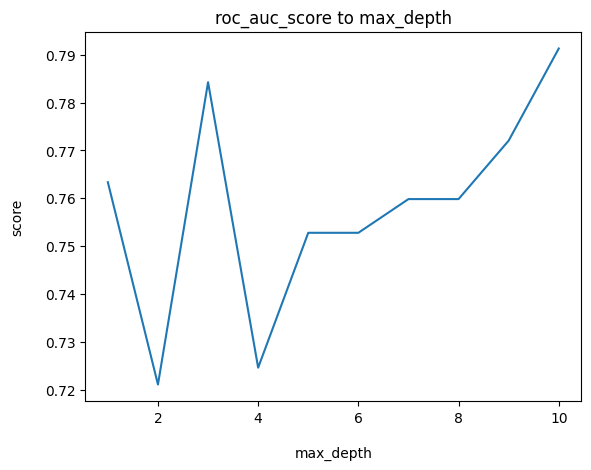

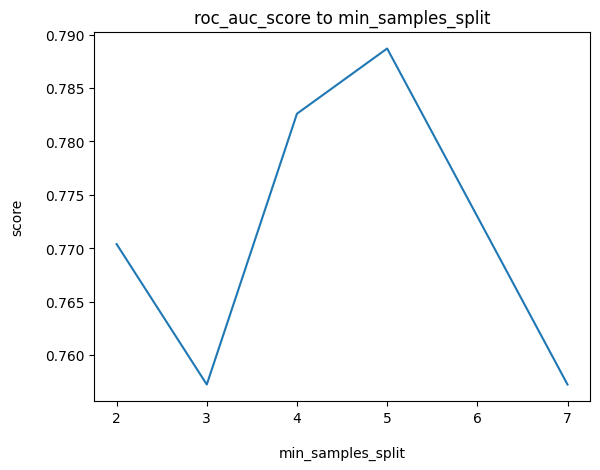

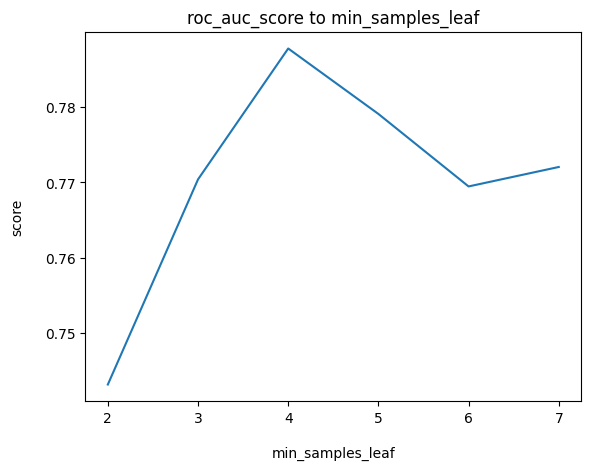

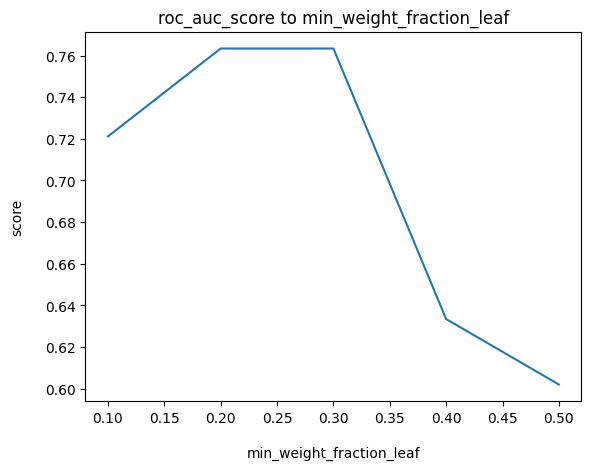

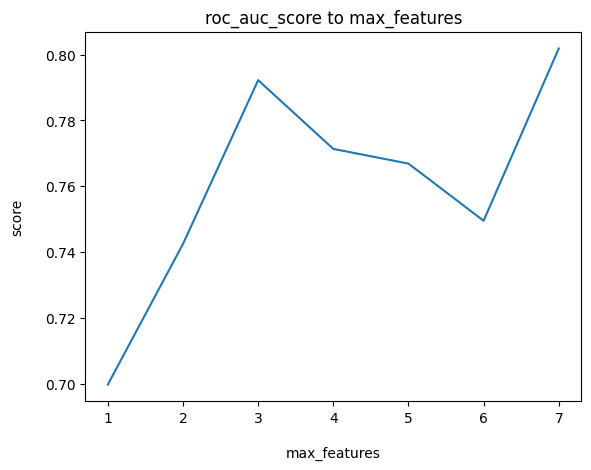

In [8]:
build_graphs(DecisionTreeClassifier, params)

Создание дерева с лучшими параметрами

0.7633677298311444
DecisionTreeClassifier(max_depth=7, max_features=3, min_samples_leaf=2,
                       min_samples_split=5, min_weight_fraction_leaf=0.1)


[Text(0.5, 0.875, 'x[1] <= 0.5\ngini = 0.477\nsamples = 400\nvalue = [243, 157]'),
 Text(0.3, 0.625, 'x[5] <= 0.097\ngini = 0.4\nsamples = 141\nvalue = [39, 102]'),
 Text(0.2, 0.375, 'x[5] <= 0.03\ngini = 0.465\nsamples = 98\nvalue = [36, 62]'),
 Text(0.1, 0.125, 'gini = 0.488\nsamples = 52\nvalue = [22, 30]'),
 Text(0.3, 0.125, 'gini = 0.423\nsamples = 46\nvalue = [14, 32]'),
 Text(0.4, 0.375, 'gini = 0.13\nsamples = 43\nvalue = [3, 40]'),
 Text(0.7, 0.625, 'x[5] <= 0.021\ngini = 0.335\nsamples = 259\nvalue = [204, 55]'),
 Text(0.6, 0.375, 'gini = 0.227\nsamples = 138\nvalue = [120, 18]'),
 Text(0.8, 0.375, 'x[5] <= 0.058\ngini = 0.425\nsamples = 121\nvalue = [84, 37]'),
 Text(0.7, 0.125, 'gini = 0.375\nsamples = 64\nvalue = [48, 16]'),
 Text(0.9, 0.125, 'gini = 0.465\nsamples = 57\nvalue = [36, 21]')]

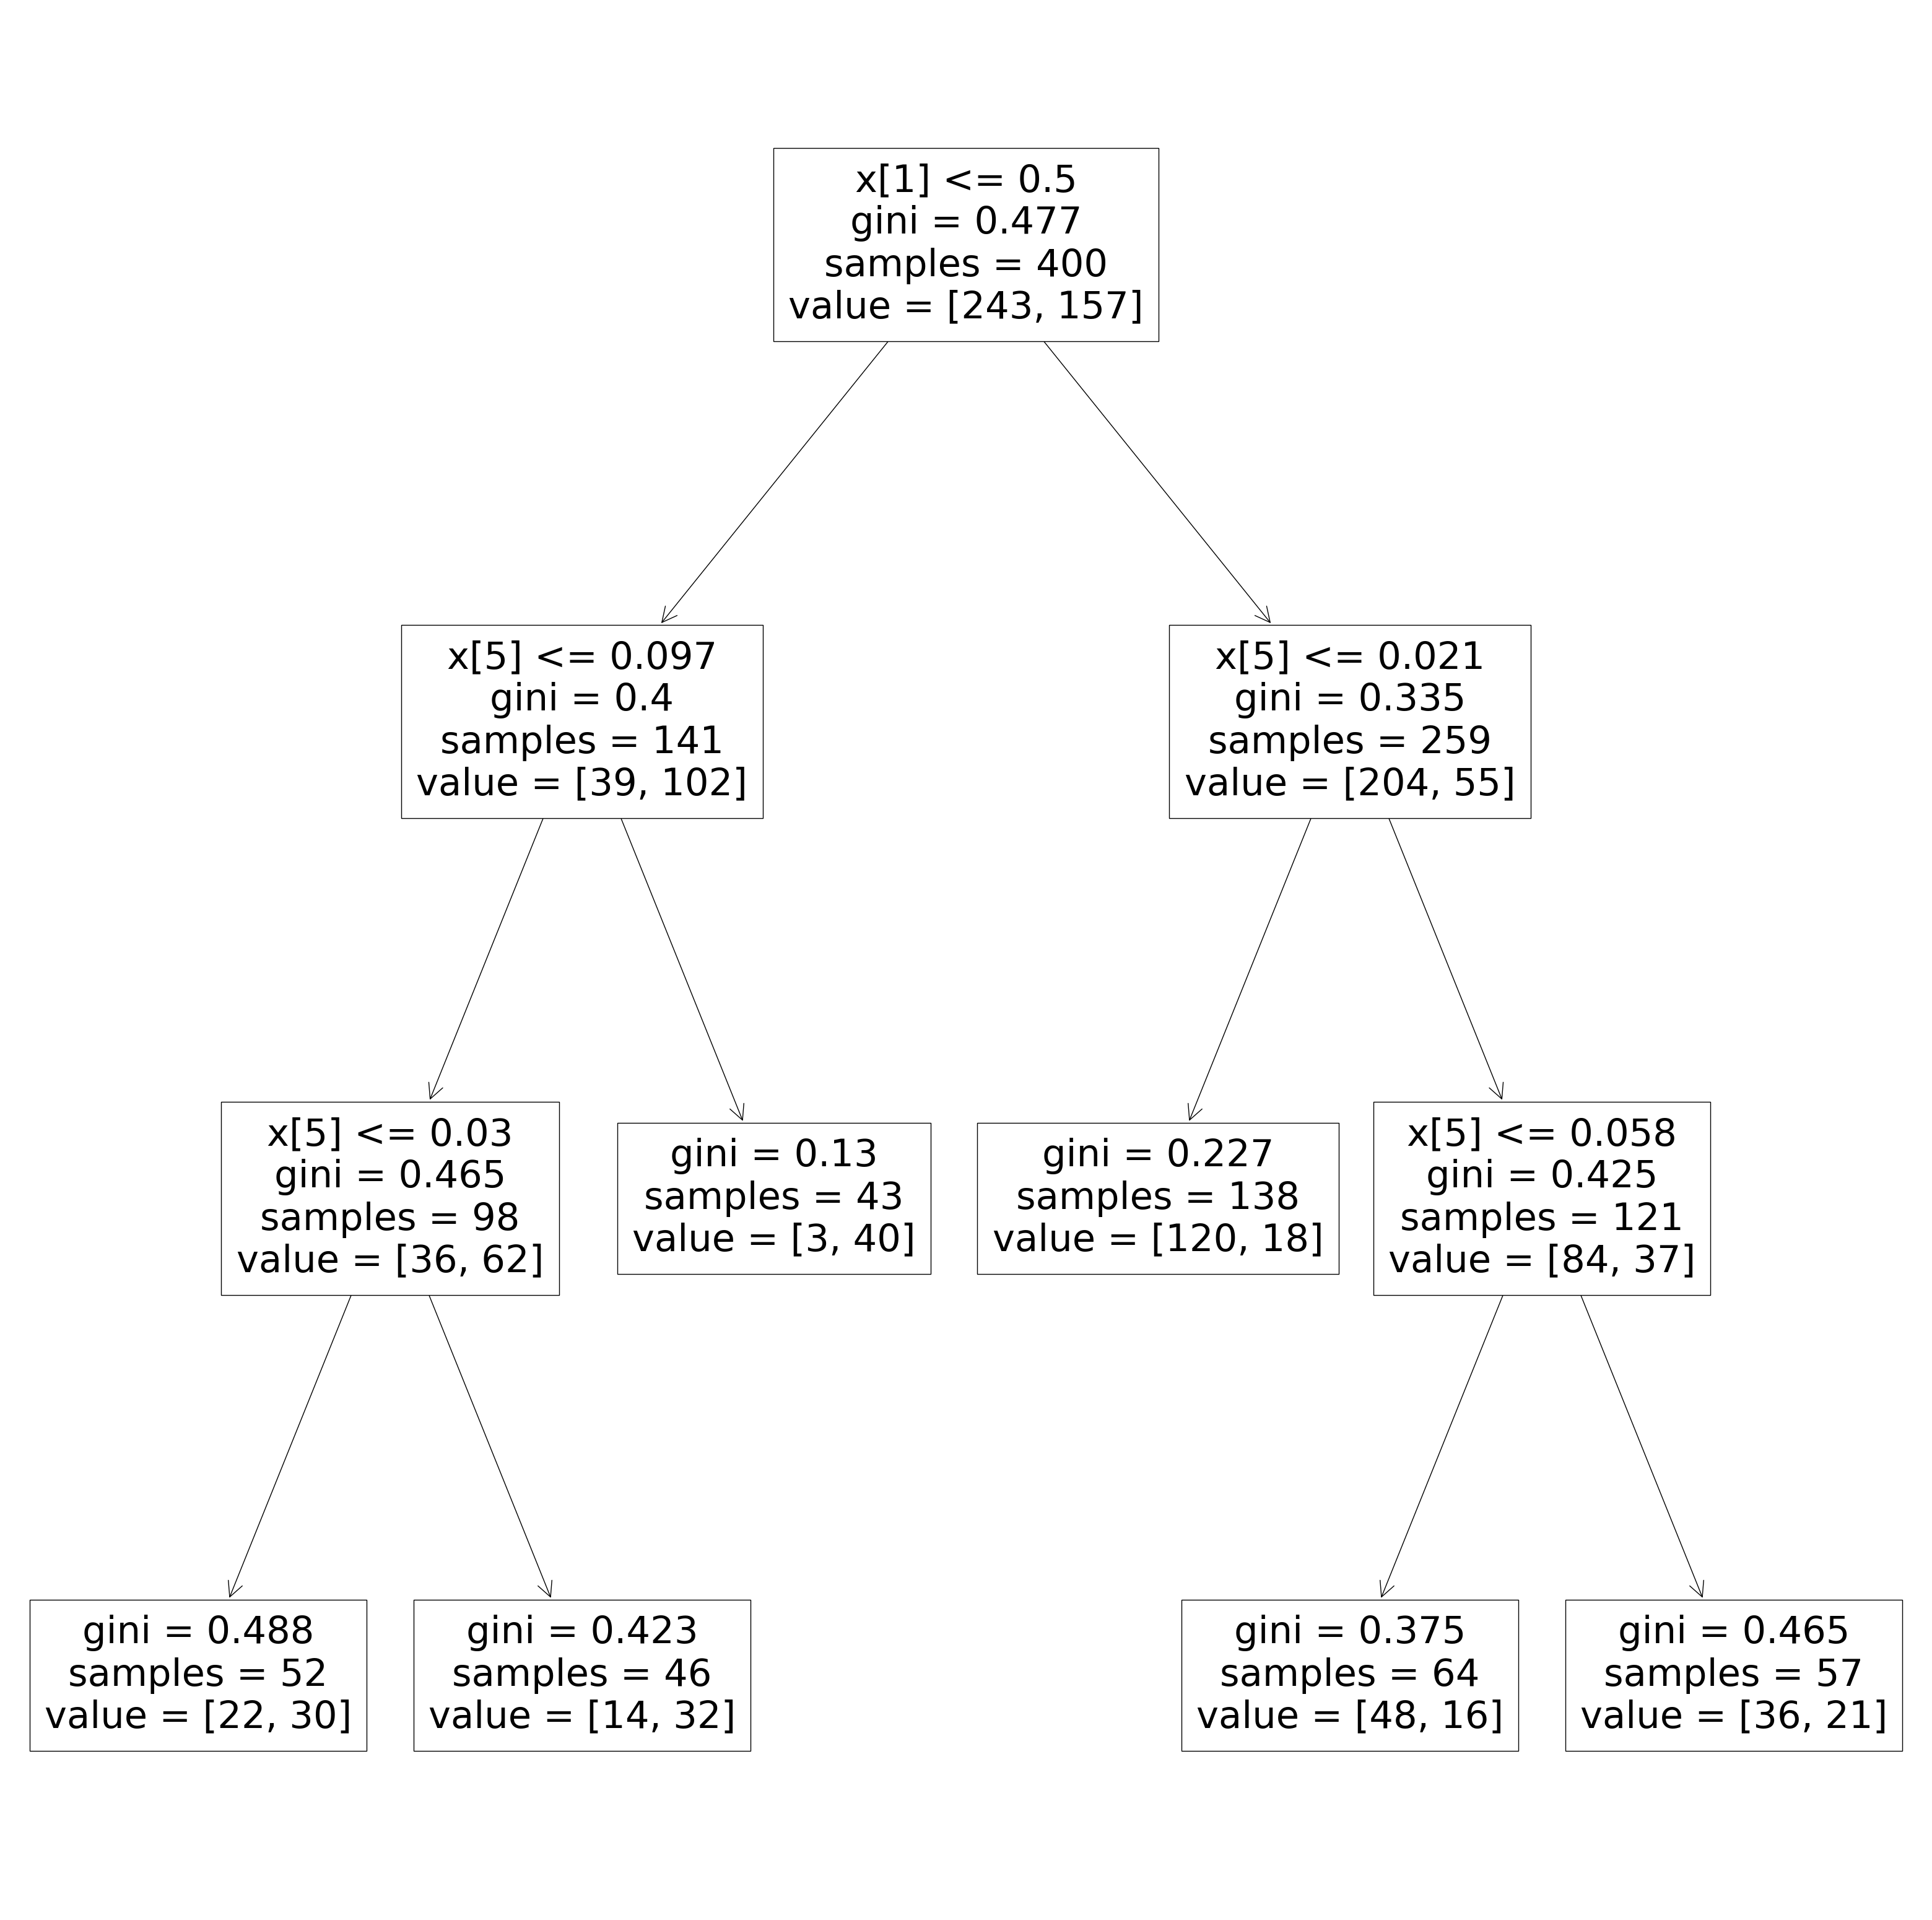

In [9]:
param_grid = {
    "max_depth": range(7, 10),
    "min_samples_split": range(5, 8),
    "min_samples_leaf": range(2, 4),
    "min_weight_fraction_leaf": list(map(lambda x: x / 10, range(1, 4))),
    "max_features": [2,3,4,7]
}
grid = GridSearchCV(DecisionTreeClassifier(splitter='best'), param_grid)
grid.fit(x_train, y_train)
clf = grid.best_estimator_
print(roc_auc_score(y_test, clf.predict(x_test)))
print(clf)
pyplot.figure(figsize=(40,40))
plot_tree(clf)

Обрезка дерева

После обрезки дерева score изменился с 0.7633677298311444 на 0.7633677298311444
0.7633677298311444
DecisionTreeClassifier(max_depth=7, max_features=3, min_samples_leaf=2,
                       min_samples_split=5, min_weight_fraction_leaf=0.1)


[Text(0.4230769230769231, 0.9, 'x[1] <= 0.5\ngini = 0.477\nsamples = 400\nvalue = [243, 157]'),
 Text(0.15384615384615385, 0.7, 'x[6] <= 1.5\ngini = 0.4\nsamples = 141\nvalue = [39, 102]'),
 Text(0.07692307692307693, 0.5, 'gini = 0.286\nsamples = 52\nvalue = [9, 43]'),
 Text(0.23076923076923078, 0.5, 'x[4] <= 0.5\ngini = 0.447\nsamples = 89\nvalue = [30, 59]'),
 Text(0.15384615384615385, 0.3, 'gini = 0.423\nsamples = 46\nvalue = [14, 32]'),
 Text(0.3076923076923077, 0.3, 'gini = 0.467\nsamples = 43\nvalue = [16, 27]'),
 Text(0.6923076923076923, 0.7, 'x[5] <= 0.021\ngini = 0.335\nsamples = 259\nvalue = [204, 55]'),
 Text(0.5384615384615384, 0.5, 'x[5] <= 0.015\ngini = 0.227\nsamples = 138\nvalue = [120, 18]'),
 Text(0.46153846153846156, 0.3, 'gini = 0.117\nsamples = 48\nvalue = [45, 3]'),
 Text(0.6153846153846154, 0.3, 'x[5] <= 0.015\ngini = 0.278\nsamples = 90\nvalue = [75, 15]'),
 Text(0.5384615384615384, 0.1, 'gini = 0.255\nsamples = 40\nvalue = [34, 6]'),
 Text(0.6923076923076923, 0

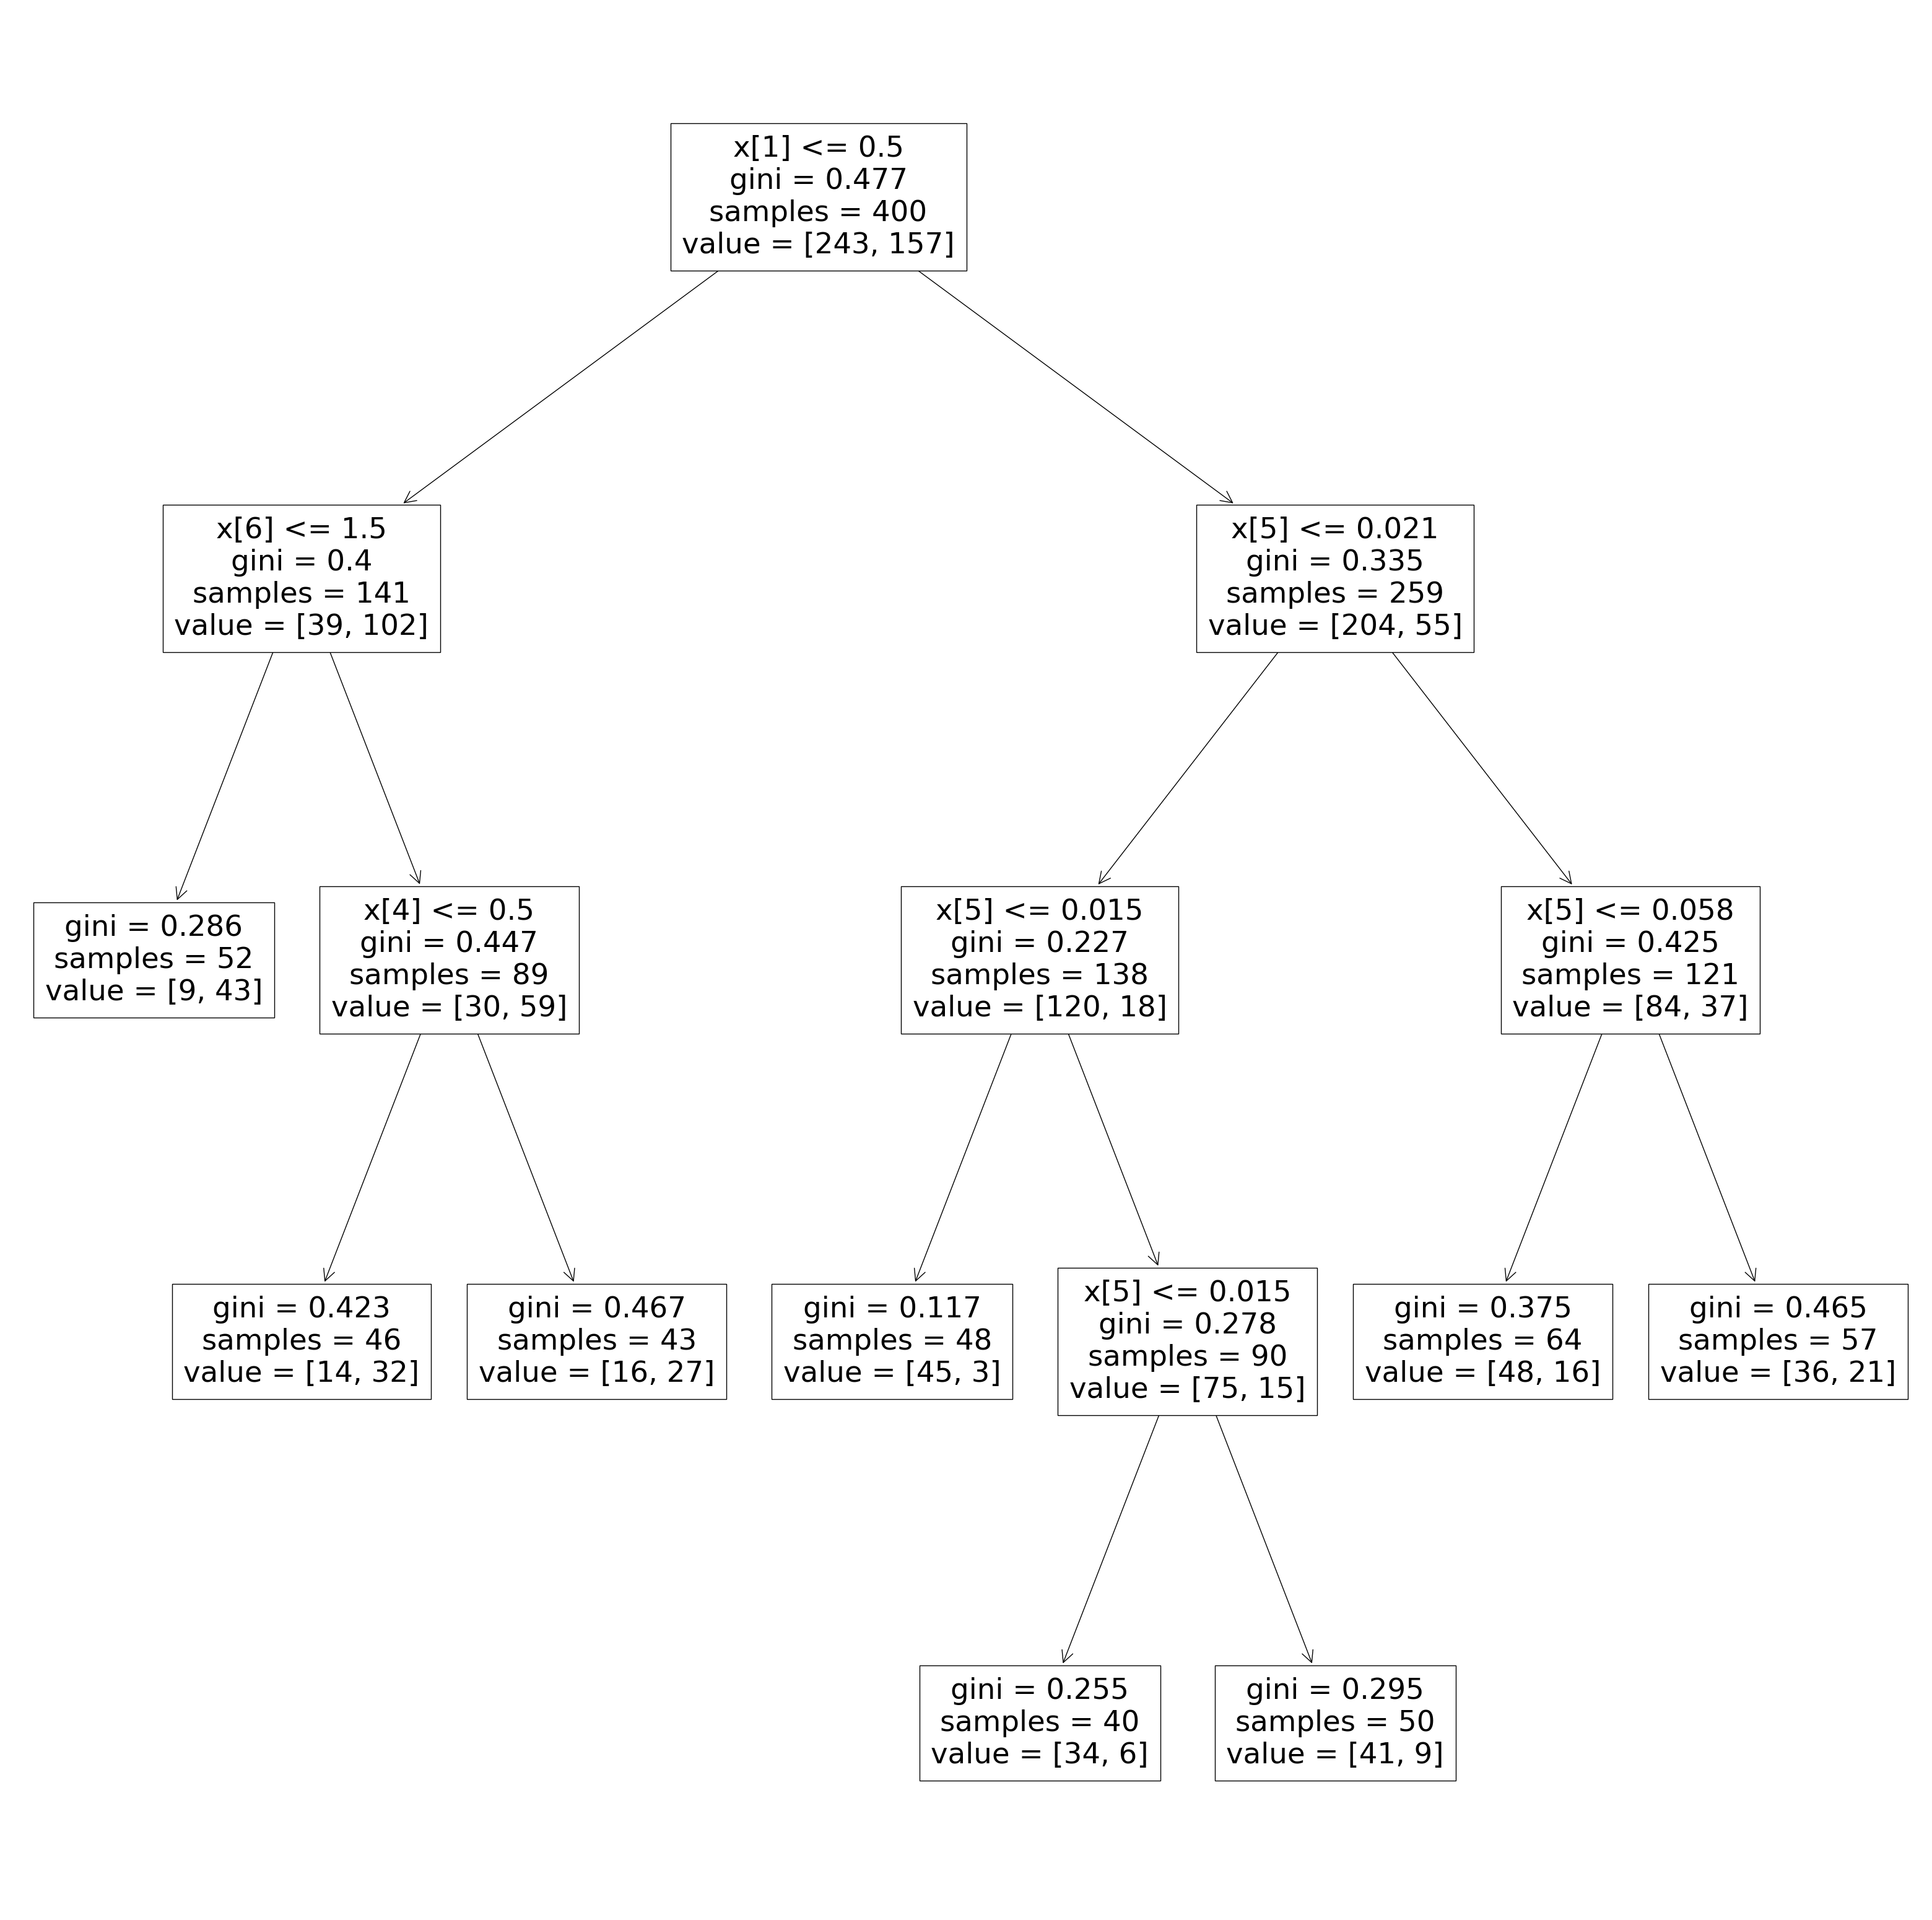

In [10]:
clf = cut_tree(clf)
path = clf.cost_complexity_pruning_path(x_train, y_train)
best_clf_score = roc_auc_score(y_test, clf.predict(x_test))
print(best_clf_score)
print(clf)
pyplot.figure(figsize=(40,40))
plot_tree(clf)

# Регрессия

Чтение данных

In [11]:
frame = pandas.read_csv("train3.csv")
frame = frame.drop(columns='id')
columns = [column for column in frame]
input_columns = columns[1:-1]
output_column = columns[-1]
numeric = ['Количество.комнат', 'Общая.площадь', 'Этаж', 'Этажей.в.доме', 'Год.постройки', 'Школа.1000', 'ВУЗ.1000', 'ТЦ.1000', 'Стоматология.1000', 'Почта.1000', 'Поликлиника.1000', 'Парк.1000', 'Остановка.1000', 'Одежда..1000', 'Супер3кет.1000', 'Кинотеатр.1000', 'Кафе.1000', 'АЗС.1000', 'Детский.сад.1000', 'Бар.1000', 'Банк.1000', 'Аптека.1000', 'Цена']


Обработка данных в таблице

In [12]:
corr_df = frame.corr()
corr_df = corr_df.sort_values(by = 'Цена', key=lambda x: abs(x))
columns = []
for i, x in zip(corr_df.index, corr_df['Цена']):
    if x >= 0.27:
        columns.append(i)
frame = frame[columns]
corr_df = frame.corr()
removed = set()
for row in corr_df.iterrows():
    row = row[0]
    for column in corr_df.columns:
        if 0.8 <= corr_df[row][column] < 1:
            removed.add(max([row, column], key=lambda x: abs(corr_df[x]['Цена'])))
corr_df = corr_df.drop(index=removed,  columns=removed)
input_columns = columns[:]
input_columns.remove('Цена')
frame = frame[columns]

In [13]:
frame

,Кафе.1000,Балкон,Остановка.1000,Лифт,Банк.1000,Одежда..1000,Аптека.1000,Бар.1000,Мусоропровод,Раздельный.санузел,Стоматология.1000,Количество.комнат,Общая.площадь,Цена
0,7,1,11,0,7,2,18,2,0,0,7,2,46.0,2350000.0
1,7,1,8,0,4,3,11,1,0,0,5,2,44.6,1799000.0
2,5,0,13,1,7,4,15,3,1,0,8,2,53.0,2800000.0
3,55,1,16,0,32,31,17,28,0,0,15,2,64.0,3970000.0
4,2,0,2,0,3,1,6,0,1,0,2,1,33.3,1880000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,2,1,6,1,3,2,5,0,1,0,2,1,38.0,1700000.0
804,19,1,20,0,10,45,17,4,0,0,14,3,46.0,2400000.0
805,0,0,2,1,0,0,3,1,1,0,0,1,34.0,1950000.0
806,7,0,9,0,5,2,14,2,0,0,6,2,46.0,2400000.0


In [14]:
x = frame[input_columns]
y = frame[output_column]
x_train, x_test, y_train, y_test = train_test_split(x, y)

Построение дерева регрессии

[Text(0.5268182683935568, 0.9722222222222222, 'x[12] <= 50.45\nsquared_error = 1204978278828.3\nsamples = 606\nvalue = 2725325.409'),
 Text(0.23052146821941663, 0.9166666666666666, 'x[12] <= 33.15\nsquared_error = 363272914084.686\nsamples = 333\nvalue = 1986138.132'),
 Text(0.06869013931214628, 0.8611111111111112, 'x[12] <= 25.75\nsquared_error = 183948773503.914\nsamples = 109\nvalue = 1317247.706'),
 Text(0.03199825859817153, 0.8055555555555556, 'x[12] <= 16.95\nsquared_error = 31999784517.881\nsamples = 47\nvalue = 875212.766'),
 Text(0.012189812799303439, 0.75, 'x[12] <= 13.2\nsquared_error = 10684692708.333\nsamples = 24\nvalue = 763125.0'),
 Text(0.0034828036569438396, 0.6944444444444444, 'x[4] <= 3.5\nsquared_error = 2244666666.667\nsamples = 3\nvalue = 533000.0'),
 Text(0.0017414018284719198, 0.6388888888888888, 'squared_error = 0.0\nsamples = 1\nvalue = 600000.0'),
 Text(0.00522420548541576, 0.6388888888888888, 'x[6] <= 11.0\nsquared_error = 250000.0\nsamples = 2\nvalue = 499

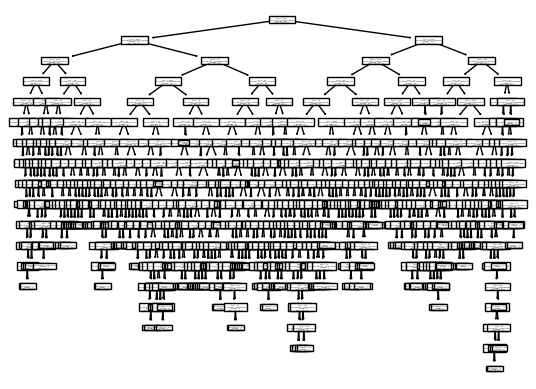

In [15]:
reg = DecisionTreeRegressor()
pyplot.figure(figsize=(40,40))
reg.fit(x_train, y_train)
plot_tree(reg)

In [16]:
params = {
    "max_depth": range(1, 11),
    "min_samples_split": range(2, len((x.columns)) + 1),
    "min_samples_leaf": range(2, len((x.columns)) + 1),
    "min_weight_fraction_leaf": list(map(lambda x: x / 10, range(1, 6))),
    "max_features": range(1, len((x.columns)) + 1)
}

Отрисовка графиков

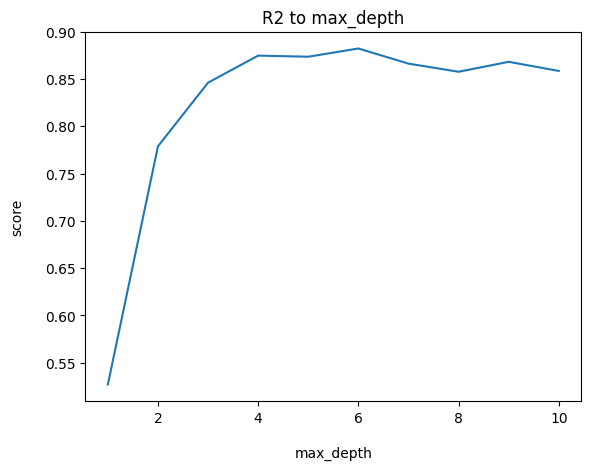

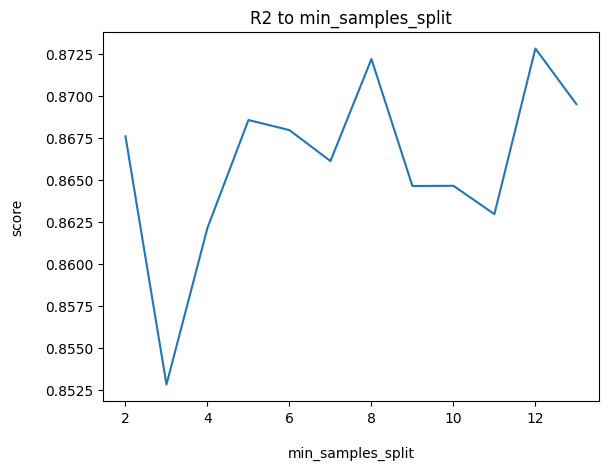

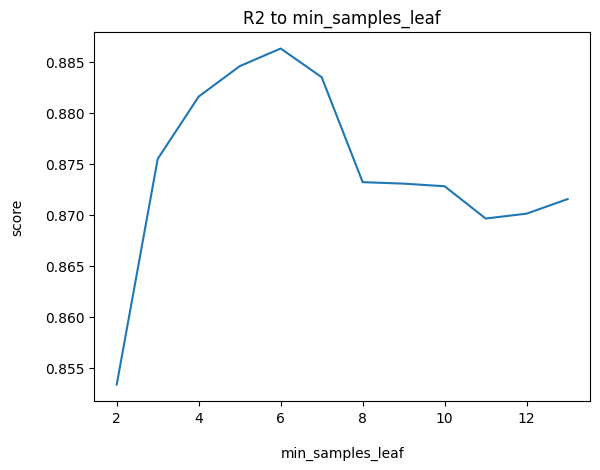

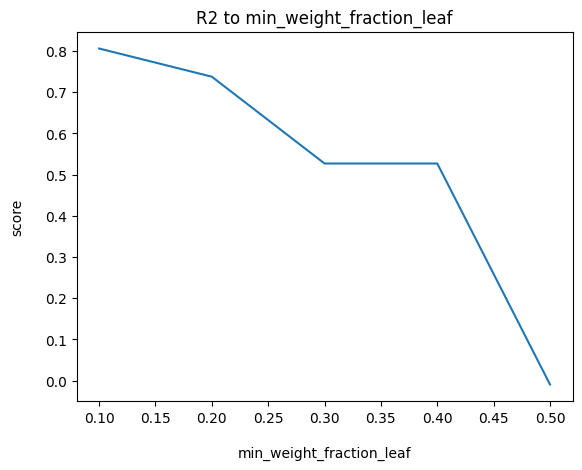

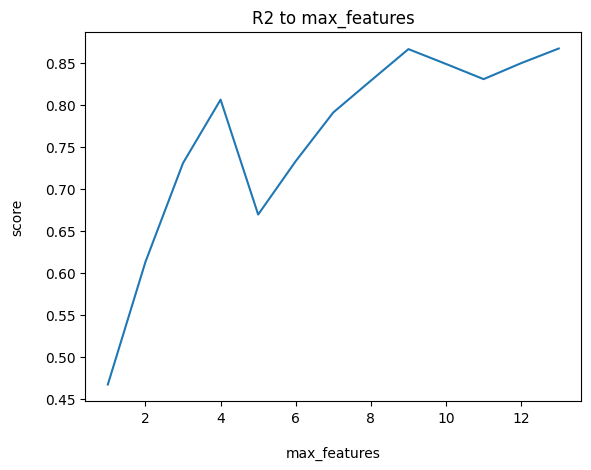

In [17]:
build_graphs(DecisionTreeRegressor, params)

0.7891368140802111
DecisionTreeRegressor(max_depth=9, max_features=9, min_samples_leaf=6,
                      min_samples_split=8, min_weight_fraction_leaf=0.1)


[Text(0.5, 0.9, 'x[12] <= 50.45\nsquared_error = 1204978278828.3\nsamples = 606\nvalue = 2725325.409'),
 Text(0.2, 0.7, 'x[12] <= 33.15\nsquared_error = 363272914084.686\nsamples = 333\nvalue = 1986138.132'),
 Text(0.1, 0.5, 'squared_error = 183948773503.914\nsamples = 109\nvalue = 1317247.706'),
 Text(0.3, 0.5, 'x[6] <= 6.5\nsquared_error = 126876582796.884\nsamples = 224\nvalue = 2311624.991'),
 Text(0.2, 0.3, 'squared_error = 131835256243.495\nsamples = 62\nvalue = 2097661.29'),
 Text(0.4, 0.3, 'x[2] <= 10.5\nsquared_error = 100752363267.653\nsamples = 162\nvalue = 2393512.333'),
 Text(0.3, 0.1, 'squared_error = 91881393666.983\nsamples = 89\nvalue = 2331561.775'),
 Text(0.5, 0.1, 'squared_error = 101184012009.757\nsamples = 73\nvalue = 2469041.096'),
 Text(0.8, 0.7, 'x[12] <= 74.35\nsquared_error = 752223023506.016\nsamples = 273\nvalue = 3626971.429'),
 Text(0.7, 0.5, 'x[12] <= 62.75\nsquared_error = 235402319135.371\nsamples = 182\nvalue = 3196841.758'),
 Text(0.6, 0.3, 'squared_

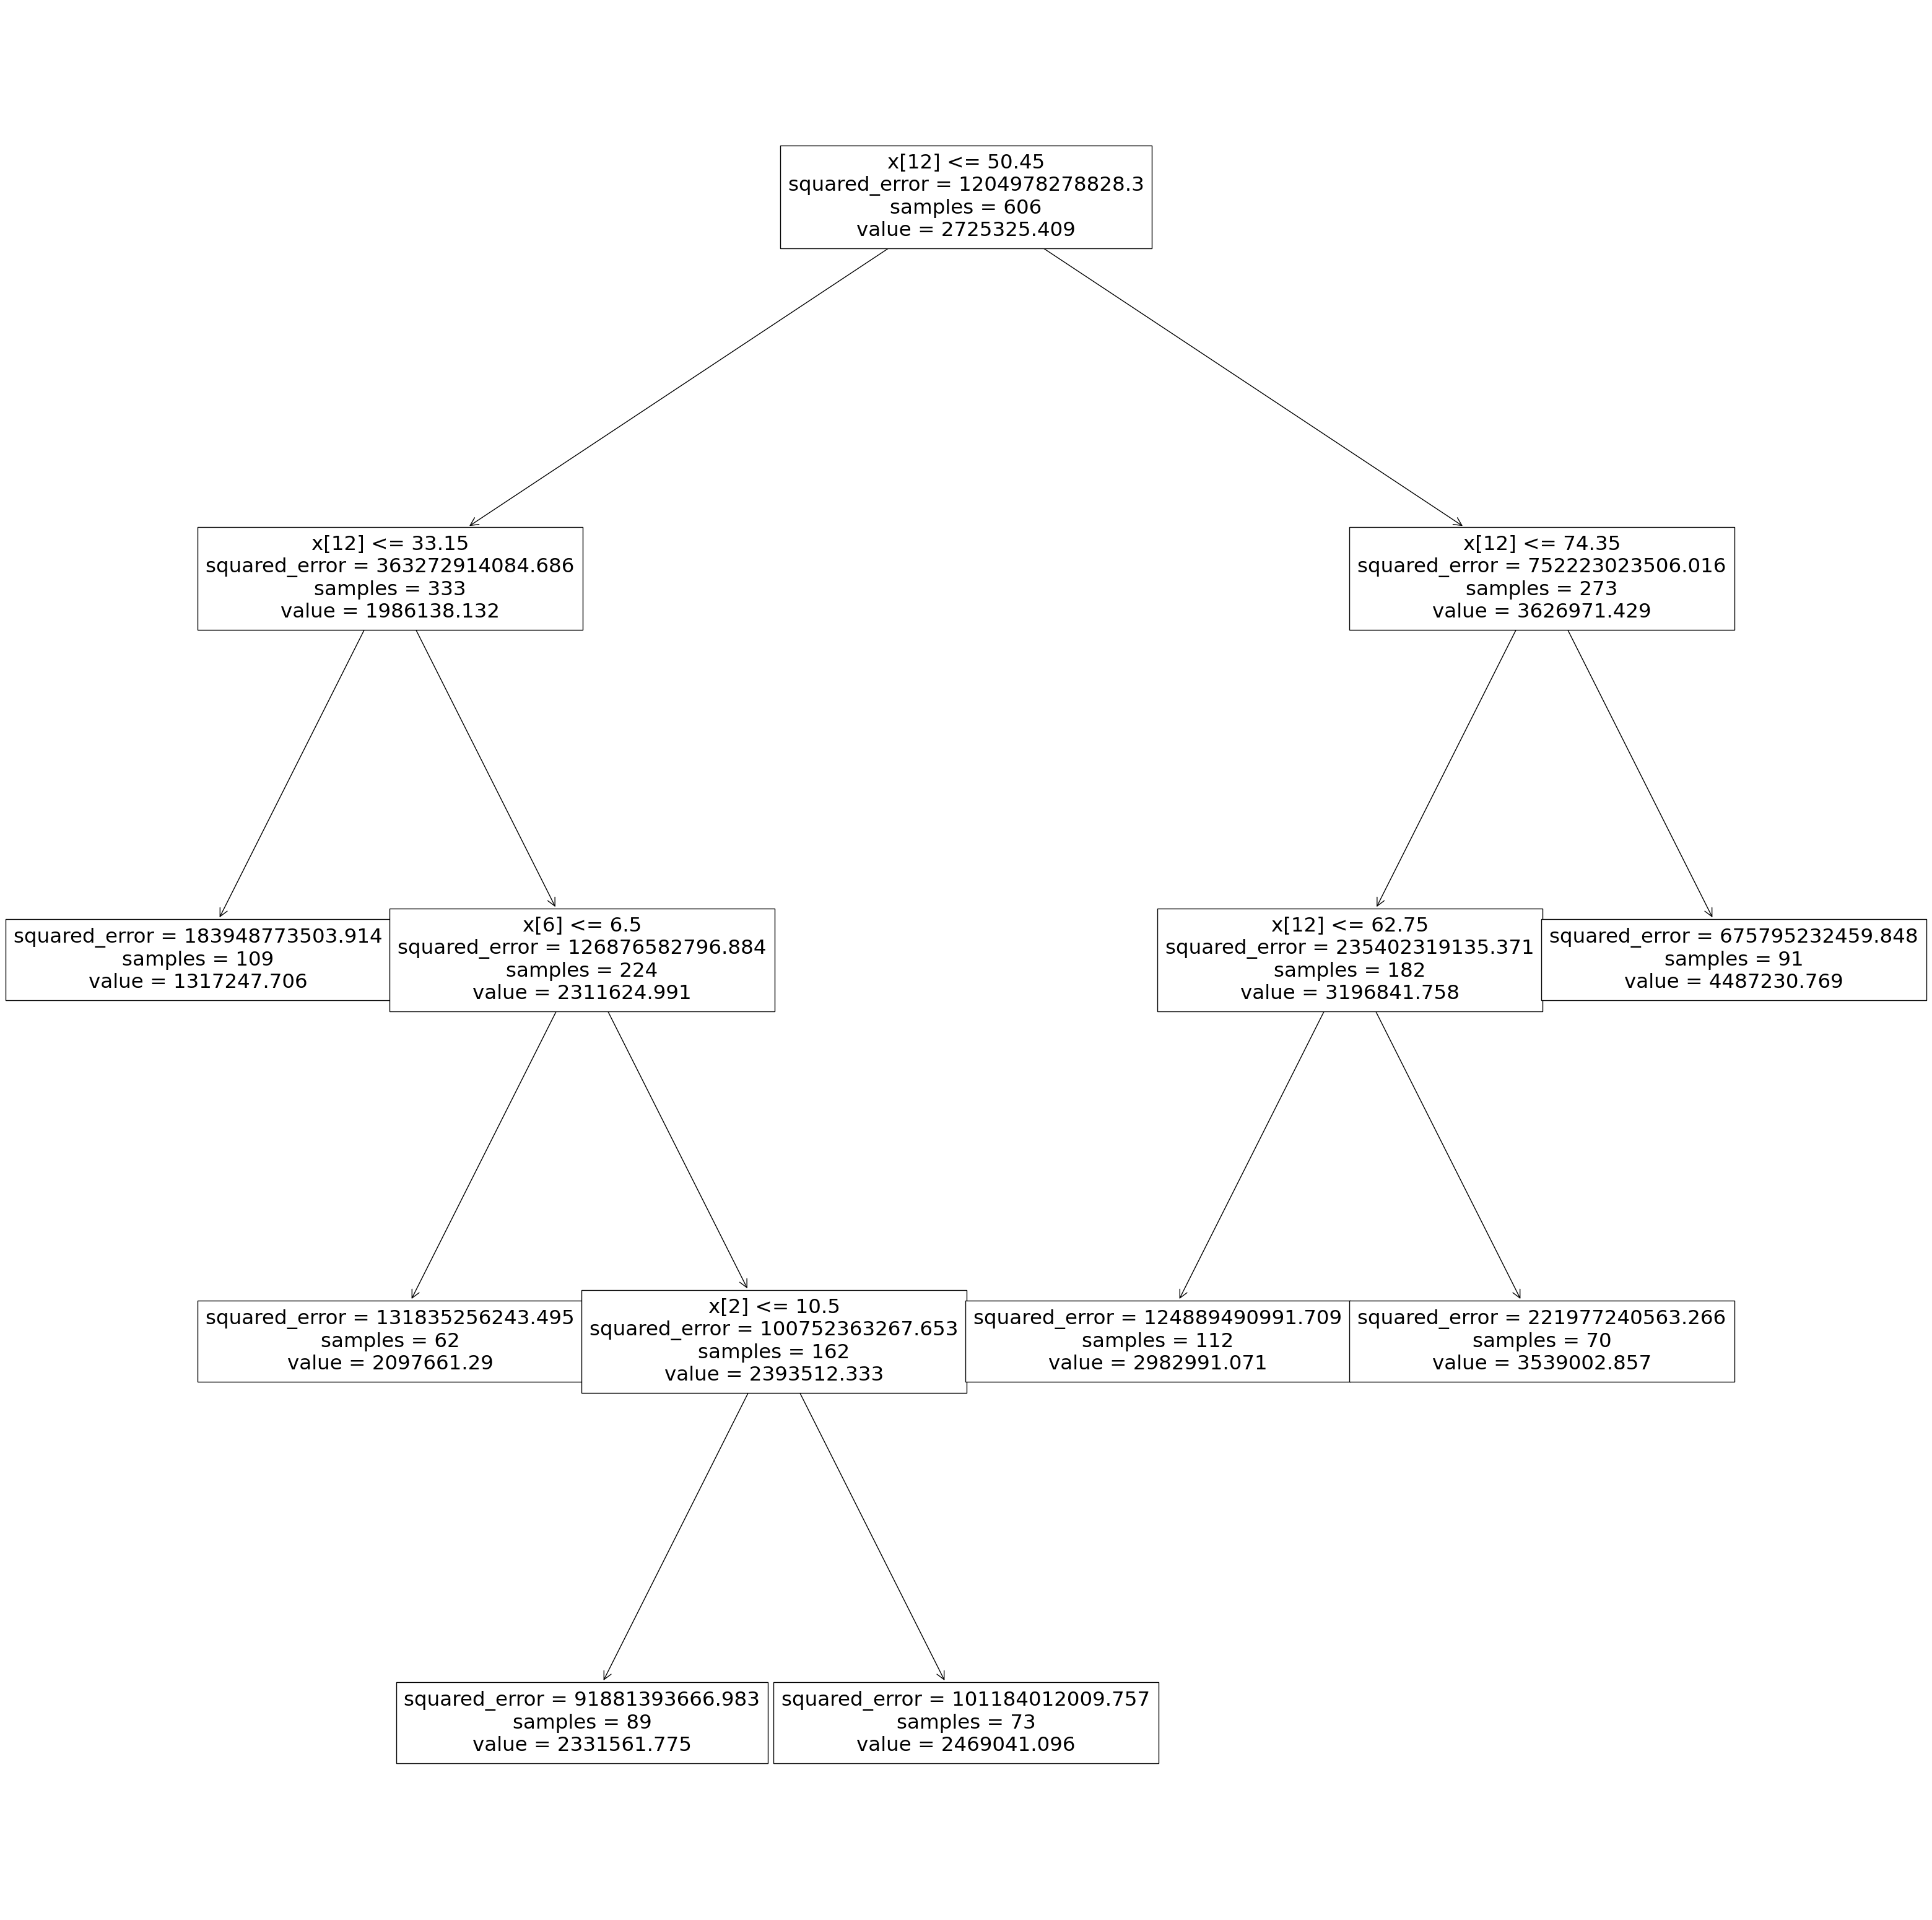

In [18]:
param_grid = {
    'max_depth': range(3, 10),
    'min_samples_split': range(6, 9),
    'min_samples_leaf': range(2, 7),
    "min_weight_fraction_leaf": list(map(lambda x: x / 10, range(1, 3))),
    'max_features': range(6, 11)
}

grid = GridSearchCV(DecisionTreeRegressor(splitter='best'), param_grid)
grid.fit(x_train, y_train)
reg = grid.best_estimator_
print(r2_score(y_test, reg.predict(x_test)))
print(reg)
pyplot.figure(figsize=(40,40))
plot_tree(reg)

После обрезки дерева score изменился с 0.7891368140802111 на 0.8033663604313701
0.8033663604313701
DecisionTreeRegressor(max_depth=9, max_features=9, min_samples_leaf=6,
                      min_samples_split=8, min_weight_fraction_leaf=0.1)


[Text(0.5555555555555556, 0.9, 'x[12] <= 50.45\nsquared_error = 1204978278828.3\nsamples = 606\nvalue = 2725325.409'),
 Text(0.3333333333333333, 0.7, 'x[11] <= 1.5\nsquared_error = 363272914084.686\nsamples = 333\nvalue = 1986138.132'),
 Text(0.2222222222222222, 0.5, 'x[12] <= 30.15\nsquared_error = 328300809985.761\nsamples = 212\nvalue = 1734103.774'),
 Text(0.1111111111111111, 0.3, 'squared_error = 125597468599.034\nsamples = 69\nvalue = 1083333.333'),
 Text(0.3333333333333333, 0.3, 'x[12] <= 36.2\nsquared_error = 123160421047.483\nsamples = 143\nvalue = 2048111.888'),
 Text(0.2222222222222222, 0.1, 'squared_error = 41937313609.468\nsamples = 65\nvalue = 1798615.385'),
 Text(0.4444444444444444, 0.1, 'squared_error = 95744460881.0\nsamples = 78\nvalue = 2256025.641'),
 Text(0.4444444444444444, 0.5, 'squared_error = 118259148406.272\nsamples = 121\nvalue = 2427718.992'),
 Text(0.7777777777777778, 0.7, 'x[12] <= 74.35\nsquared_error = 752223023506.016\nsamples = 273\nvalue = 3626971.42

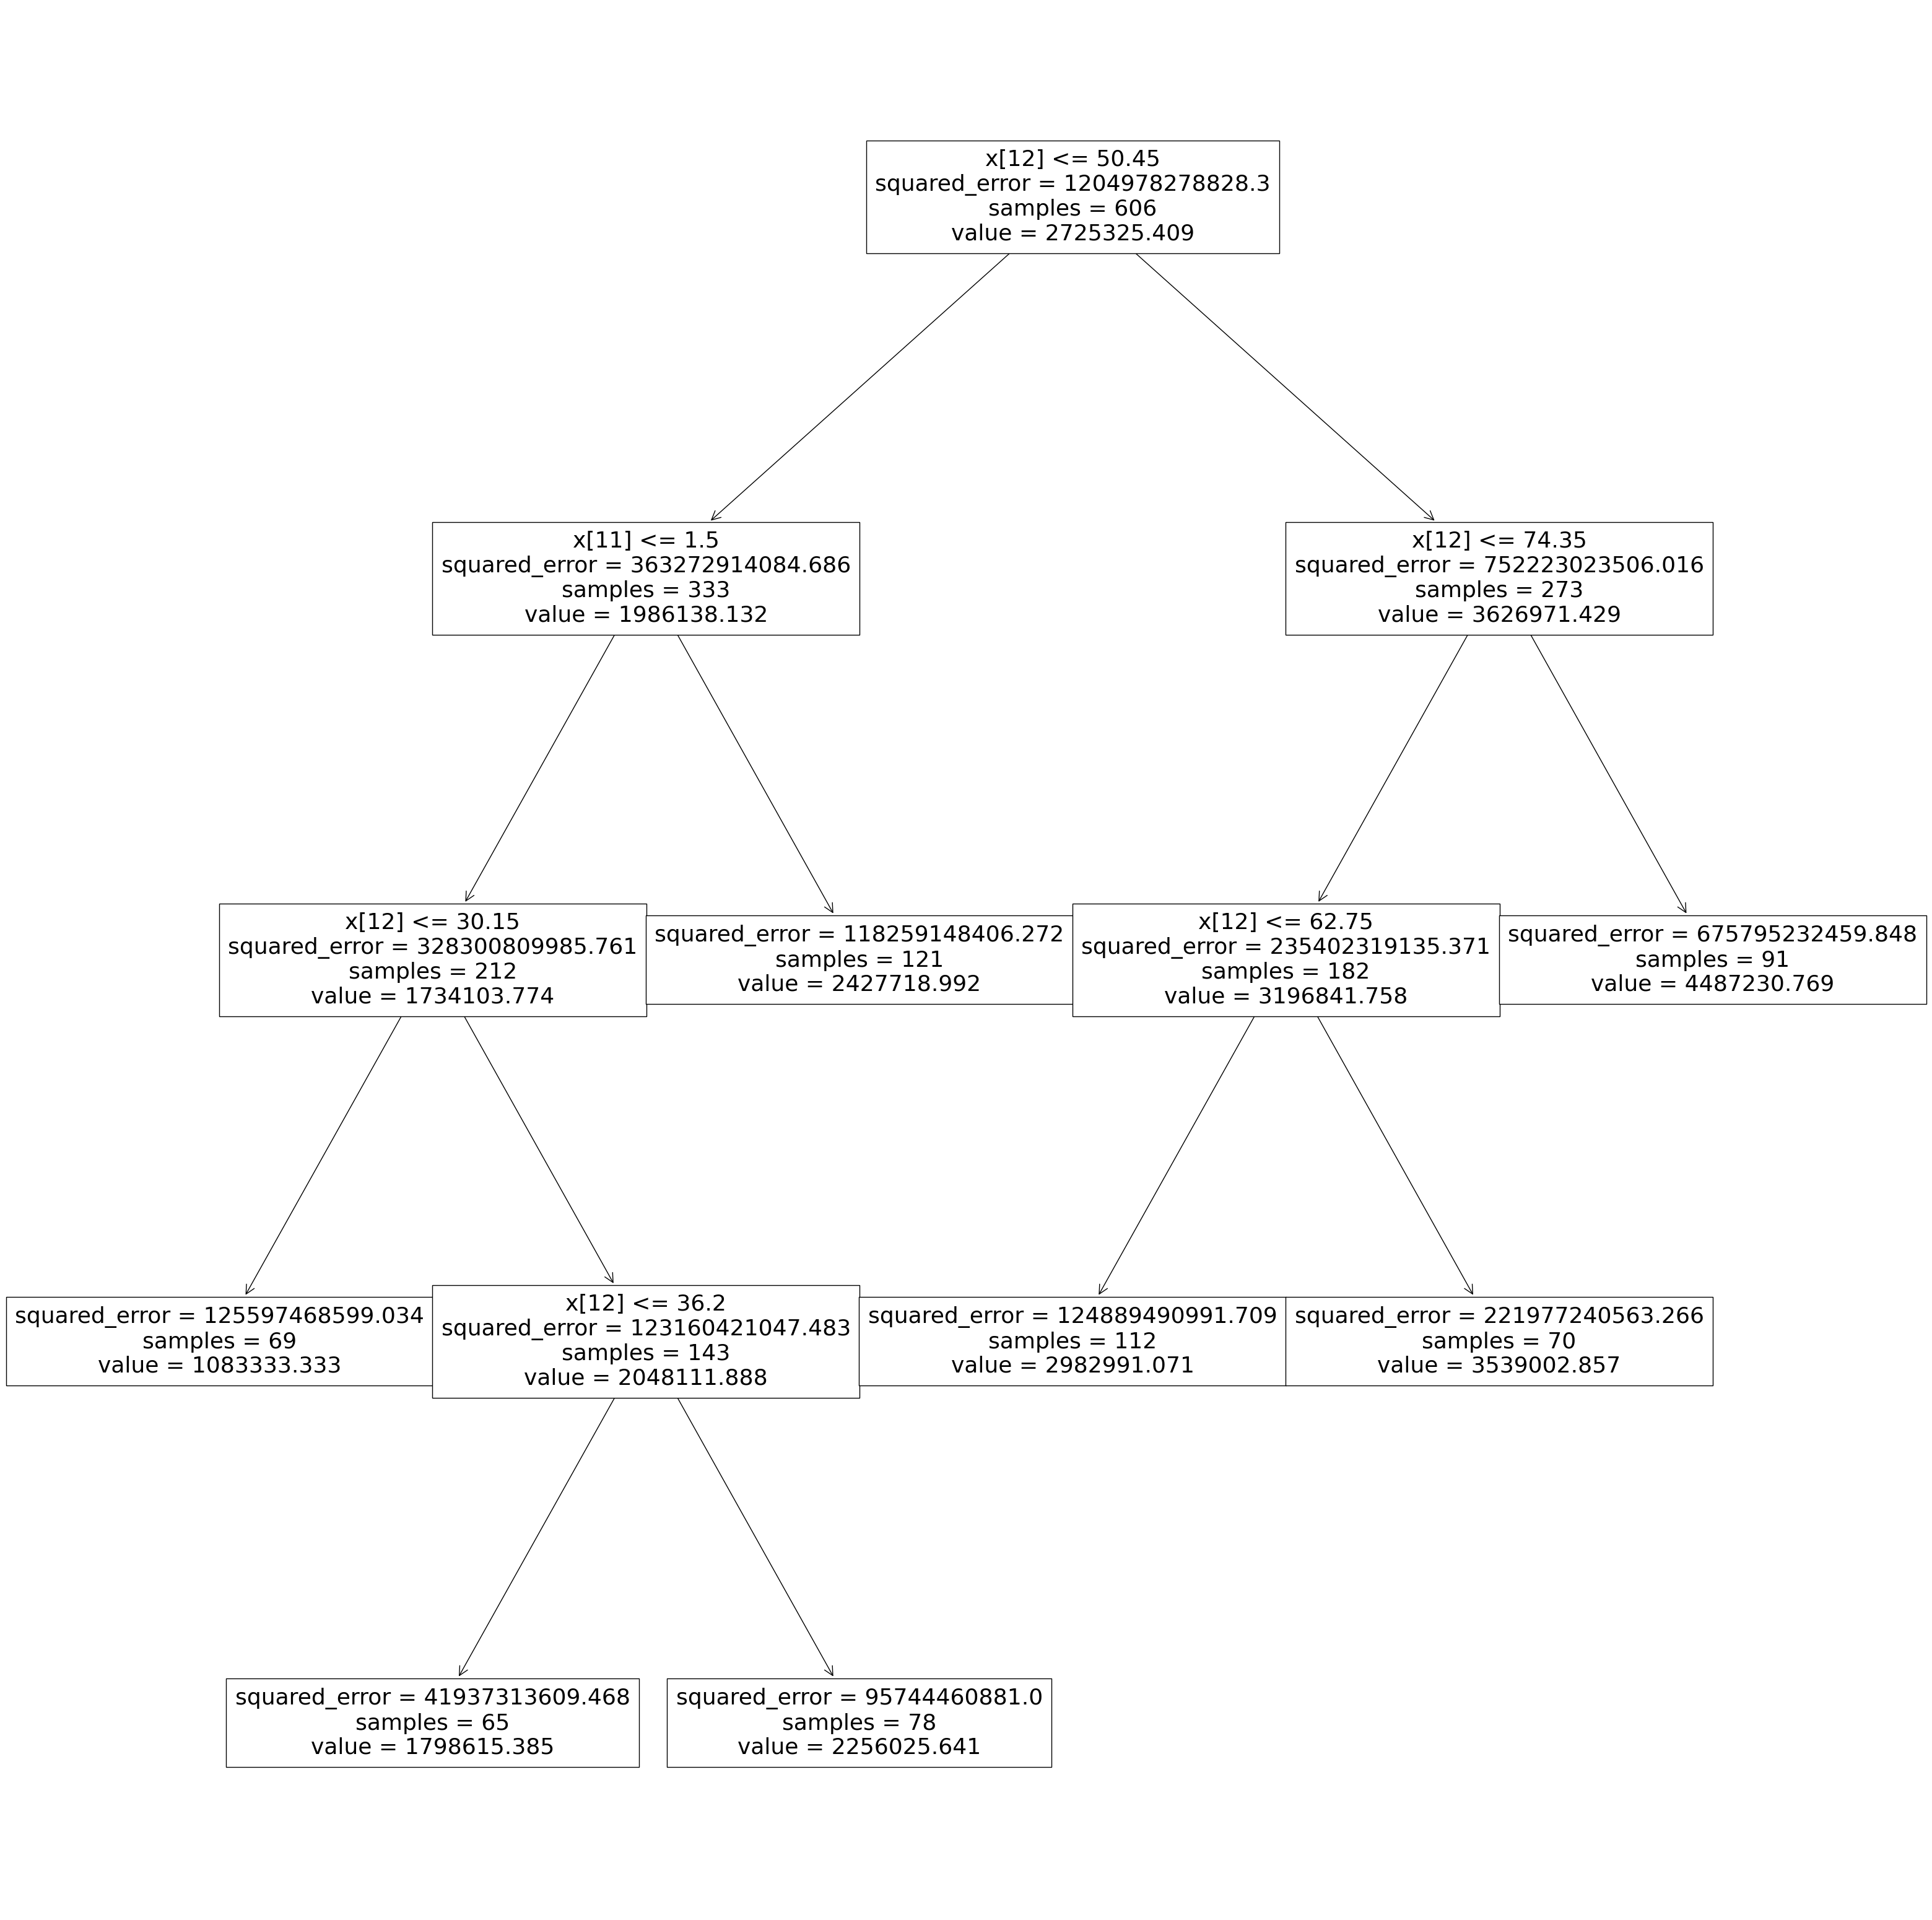

In [19]:
reg = cut_tree(reg)
path = reg.cost_complexity_pruning_path(x_train, y_train)
best_reg_score = r2_score(y_test, reg.predict(x_test))
print(best_reg_score)
print(reg)
pyplot.figure(figsize=(40,40))
plot_tree(reg)

# Сравнение с результатами практических работ 2 и 3

Классификаторы

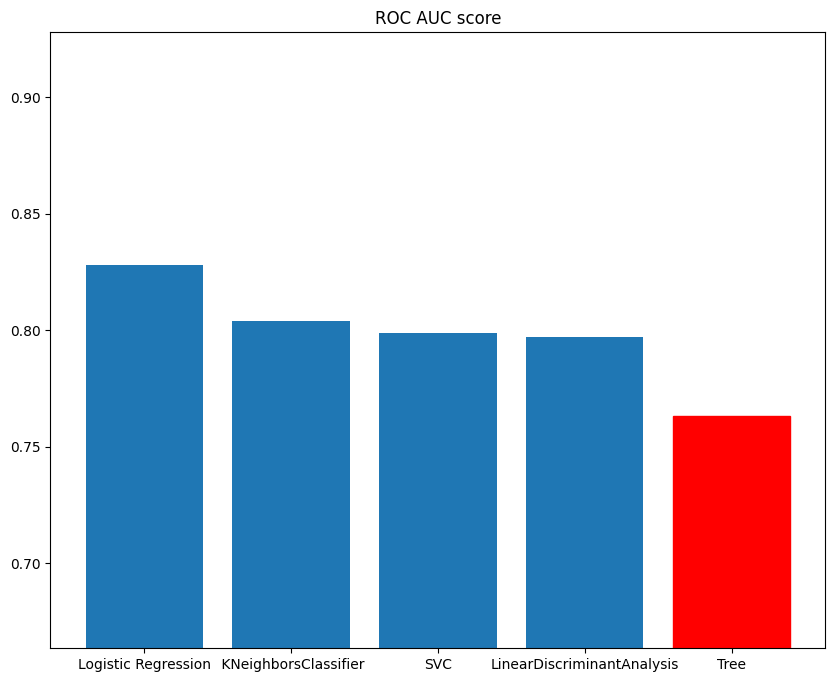

In [20]:
clf_results = {"Logistic Regression": 0.828, " KNeighborsClassifier": 0.804, "SVC": 0.799, "LinearDiscriminantAnalysis": 0.797, "Tree": best_clf_score}
pyplot.figure(figsize=(10, 8))
pyplot.title("ROC AUC score")
pyplot.ylim(min(clf_results.values()) - 0.1, min(max(clf_results.values()) + 0.1, 1))
barlist = pyplot.bar(clf_results.keys(), clf_results.values())
barlist[-1].set_color('red')
pyplot.show()

Регрессия

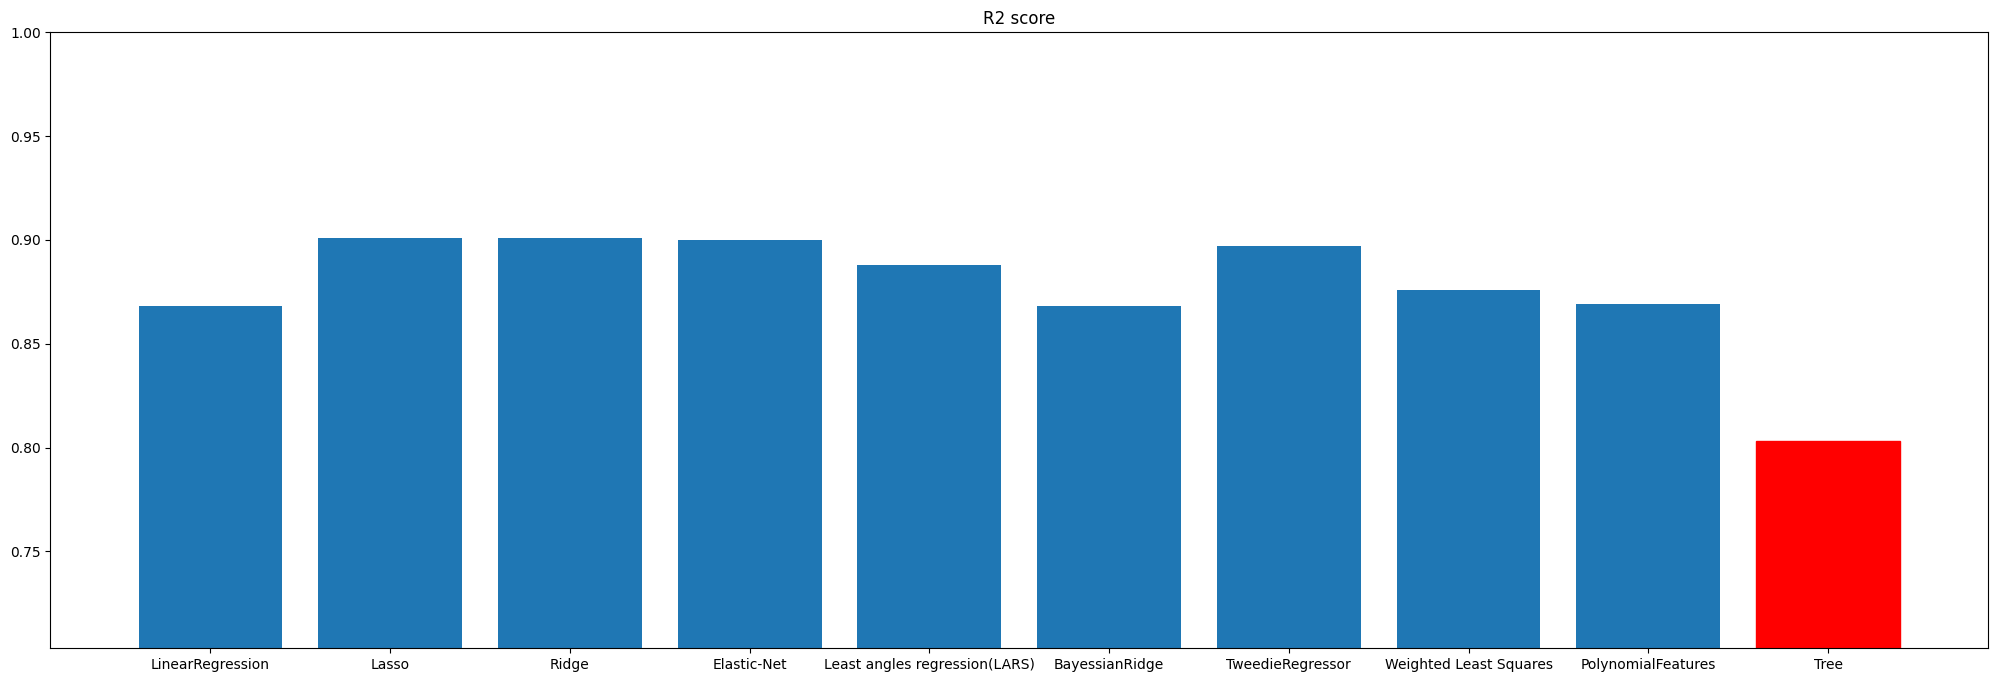

In [21]:
reg_results = {"LinearRegression": 0.868, "Lasso": 0.901, "Ridge": 0.901, "Elastic-Net": 0.900, "Least angles regression(LARS)": 0.888,
              "BayessianRidge": 0.868, "TweedieRegressor": 0.897, "Weighted Least Squares": 0.876, "PolynomialFeatures": 0.869, "Tree": best_reg_score}
pyplot.figure(figsize=(25, 8))
pyplot.title("R2 score")
pyplot.ylim(min(reg_results.values()) - 0.1, min(max(reg_results.values()) + 0.1, 1))
barlist = pyplot.bar(reg_results.keys(), reg_results.values())
barlist[-1].set_color('red')
pyplot.show()